In [ ]:
!pip uninstall numpy pmdarima -y
!pip install --no-cache-dir numpy pmdarima

In [ ]:
pip install numpy==1.26.4

In [ ]:
pip install --no-cache-dir pmdarima

In [9]:
!pip install Jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [6]:
dataset = pd.read_csv(r'C:\Users\GUilherme.costa\OneDrive - Alvarez and Marsal\Desktop\Nada\Prova_vaga\Dataset_teste_Just_BI.csv', sep =';')

In [7]:
dataset.head()

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1


In [10]:
#Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)
dataset.groupby('year')[['net_revenue','gross_revenue','boxes']].sum().style.format({'net_revenue': '{:,}','gross_revenue': '{:,}','boxes': '{:,}'})

,net_revenue,gross_revenue,boxes
year,,,
2013,"5,295,828","6,134,328","156,289"
2014,"10,161,460","11,505,225","291,647"
2015,"10,611,613","12,019,567","292,778"


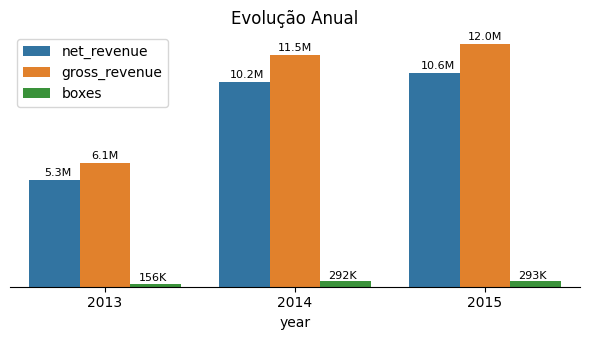

In [11]:
graf = dataset.groupby('year')[['net_revenue','gross_revenue','boxes']].sum().reset_index()

graf_melted = graf.melt(id_vars='year', var_name='metric', value_name='value')

plt.figure(figsize=(6, 3.5))

ax = sns.barplot(data=graf_melted, x='year', y='value', hue='metric', width=0.8)

plt.title('Evolução Anual')
plt.xticks(rotation=0)

ax.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

for i, year in enumerate(graf['year']):
    ax.text(i - 0.25, graf['net_revenue'].iloc[i] + 100000, 
            f"{graf['net_revenue'].iloc[i]/1e6:.1f}M", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i, graf['gross_revenue'].iloc[i] + 100000, 
            f"{graf['gross_revenue'].iloc[i]/1e6:.1f}M", 
            ha='center', va='bottom', fontsize=8)
    ax.text(i + 0.25, graf['boxes'].iloc[i] + 10000, 
            f"{graf['boxes'].iloc[i]/1e3:.0f}K", 
            ha='center', va='bottom', fontsize=8)

plt.legend(title='')
plt.tight_layout()
plt.show()

In [93]:
#Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?
dataset['customer_acquisition_channel'].unique()

array(['Paid Marketing', 'Referral'], dtype=object)

In [12]:
dataset['ticket_medio_net'] = dataset['net_revenue'] / dataset['boxes']
dataset['ticket_medio_gross'] = dataset['gross_revenue'] / dataset['boxes']

resultado = dataset.groupby(['year','customer_acquisition_channel'])[['ticket_medio_net','ticket_medio_gross']].mean()

resultado.style.format({
    'ticket_medio_net': '{:,.1f}', 
    'ticket_medio_gross': '{:,.1f}'
})

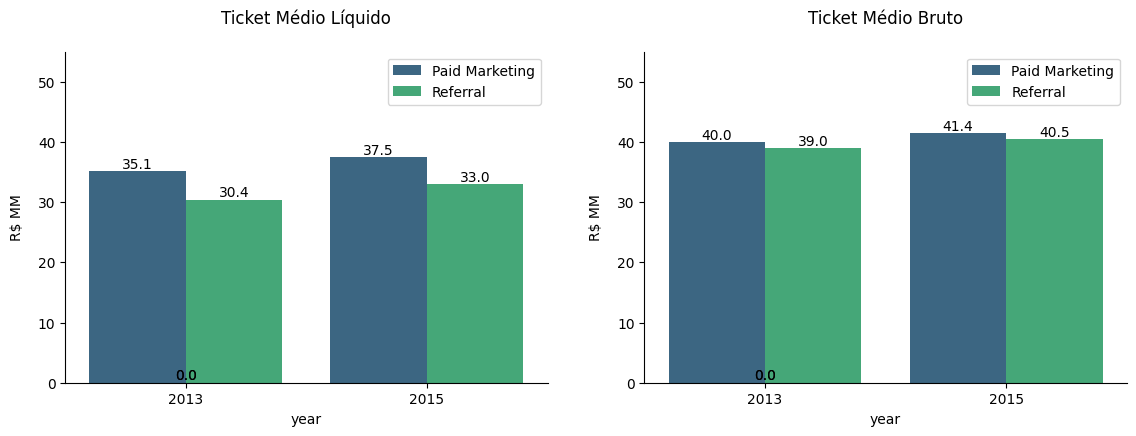

In [13]:
df_filtrado = resultado.reset_index()[resultado.reset_index()['year'].isin([2013, 2015])]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(
    data=df_filtrado,
    x='year',
    y='ticket_medio_net',
    hue='customer_acquisition_channel',
    ax=ax1,
    palette='viridis',
    width=0.8
)
ax1.set_title('Ticket Médio Líquido', pad=20)
ax1.set_ylim(0, 55)
ax1.set_ylabel('R$ MM', labelpad=10)
ax1.legend(title=None)

sns.barplot(
    data=df_filtrado,
    x='year',
    y='ticket_medio_gross',
    hue='customer_acquisition_channel',
    ax=ax2,
    palette='viridis',
    width=0.8
)
ax2.set_title('Ticket Médio Bruto', pad=20)
ax2.set_ylim(0, 55)
ax2.set_ylabel('R$ MM', labelpad=10)
ax2.legend(title=None)

for ax in (ax1, ax2):
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10
        )
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

plt.tight_layout(pad=3.0)
plt.show()

In [16]:
#Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)
dataset.columns

Index(['customer_id', 'customer_acquisition_channel', 'year', 'week',
       'net_revenue', 'gross_revenue', 'boxes', 'ticket_medio_net',
       'ticket_medio_gross'],
      dtype='object')

In [17]:
clientes_unicos = (pd.DataFrame(dataset[dataset['year'].isin([2013, 2015])].groupby('year')['customer_id'].nunique())).style.format({'customer_id': '{:,}'})
clientes_unicos

,customer_id
year,
2013,"35,851"
2015,"51,643"


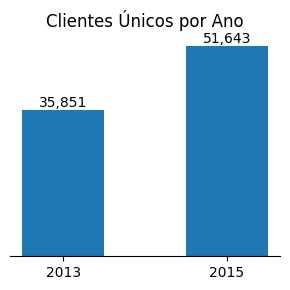

In [18]:
dados = clientes_unicos.data  
anos = dados.index
valores = dados['customer_id'].values

plt.figure(figsize=(3, 3))
bars = plt.bar(anos, valores, width=1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=10)

plt.title('Clientes Únicos por Ano')
plt.xticks(anos)

plt.gca().axes.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

# Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?



Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear,
ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.
● Qual modelo teve a melhor performance?
● Quais métricas utilizou para comparar? E por quê?
● Como realizou treino e teste?

In [19]:
forecast_base = dataset.groupby(['year', 'week'])['net_revenue'].sum()
forecast_base = forecast_base.reset_index()
forecast_base['date'] = forecast_base['year'].astype(str) + '-' + forecast_base['week']
forecast_base['date'] = pd.to_datetime(forecast_base['date'] + '-1', format='%Y-W%W-%w')

In [20]:
#Chegar se tem semanas faltantes
start = forecast_base['date'].min()
end = forecast_base['date'].max()
all = pd.date_range(start=start, end=end, freq='W-MON')

missing_weeks = all[~all.isin(forecast_base['date'])]
print(f"Semanas faltantes ({len(missing_weeks)}):\n{missing_weeks}")

Semanas faltantes (0):
DatetimeIndex([], dtype='datetime64[ns]', freq='W-MON')


<Axes: >

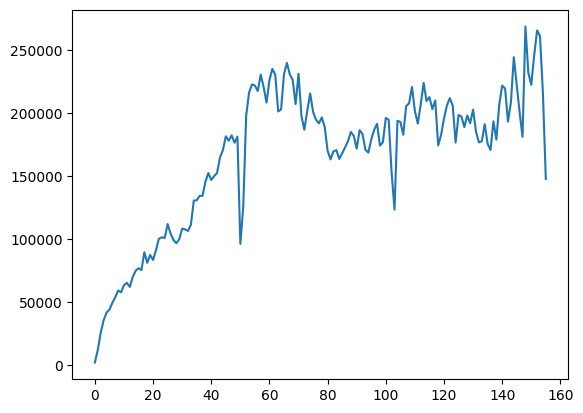

In [21]:
forecast_base['net_revenue'].plot()

In [59]:
#Arrumar a base
forecast_base = dataset.groupby(['year', 'week'])['net_revenue'].sum()

dados = forecast_base.reset_index()
dados['week_num'] = dados['week'].str.extract(r'(\d+)').astype(int) 
dados['year_week'] = dados['year'].astype(str) + '-' + dados['week_num'].astype(str).str.zfill(2)

dados['time_index'] = np.arange(len(dados))
X = dados[['time_index']]
y = dados['net_revenue'] 

In [60]:
#Checar estacionariedade
result = adfuller(y.dropna())
print(f'P-valor: {result[1]}')

P-valor: 0.1542128142373842


In [63]:
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
modelo_arima = auto_arima(
    y_train,
    start_p=1,    
    start_q=1,   
    d=None,       
    test='adf',   
    seasonal=True, 
    trace=True,   
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True 
)

train_pred = modelo_arima.predict_in_sample()
test_pred = modelo_arima.predict(n_periods=len(y_test))

def calculate_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

metrics_train = calculate_metrics(y_train, train_pred)
metrics_test = calculate_metrics(y_test, test_pred)

results = pd.DataFrame({
    'Treino': metrics_train,
    'Teste': metrics_test
}).T

results_formatted = results.style.format({
    'MAE': '{:,.1f}',
    'RMSE': '{:,.1f}',
    'MAPE': '{:,.1f}%'
}).set_caption("Desempenho do Modelo ARIMA").background_gradient(cmap='Blues', axis=0)

print("\n" + "="*50)
print("Comparação Treino vs Teste")
print("="*50)
display(results_formatted)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2745.012, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2746.609, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2748.407, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2747.868, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2745.803, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2734.109, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2733.885, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2733.810, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2735.830, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2735.797, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2737.808, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2735.037, Time=0.02 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.304 seconds

Comparação Treino vs Teste


,MAE,RMSE,MAPE
Treino,"10,024.8","15,505.2",8.1%
Teste,"29,894.0","36,200.3",15.9%


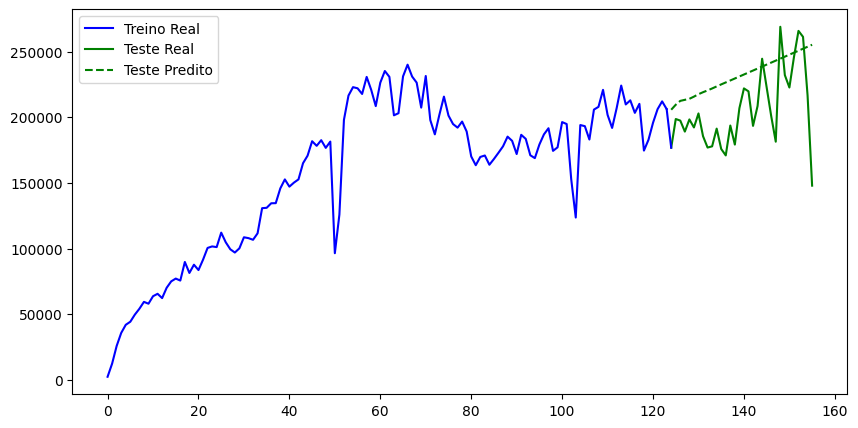

In [73]:
plt.figure(figsize=(10, 5))

plt.plot(y_train.index, y_train, label='Treino Real', color='blue')
plt.plot(y_test.index, y_test, label='Teste Real', color='green')

plt.plot([y_train.index[-1], y_test.index[0]], 
         [y_train.iloc[-1], y_test.iloc[0]], 
         color='blue', linestyle='-')

plt.plot(y_test.index, test_pred, label='Teste Predito', linestyle='--', color='green')

plt.legend()
plt.show()


Comparação Treino vs Teste - Regressão Linear


,MAE,RMSE,MAPE
Treino,"29,729.8","36,458.9",53.8%
Teste,"50,744.6","56,376.9",26.7%


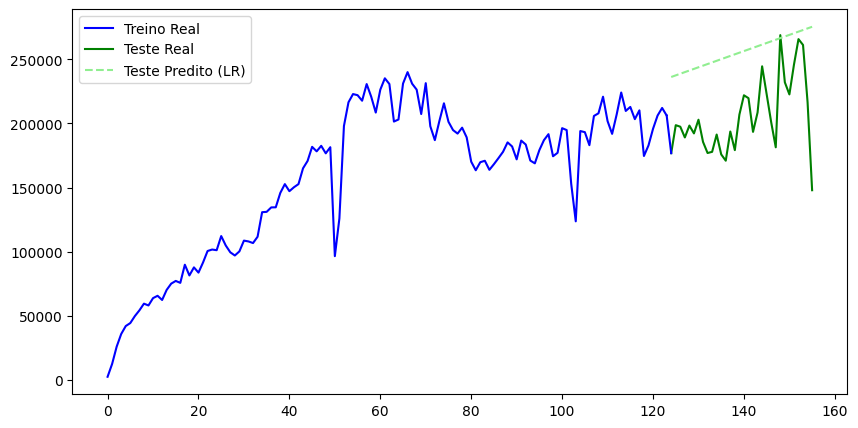

In [75]:
X_train = np.arange(len(y_train)).reshape(-1, 1)
X_test = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1)

modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

train_pred_lr = modelo_lr.predict(X_train)
test_pred_lr = modelo_lr.predict(X_test)

def calculate_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

metrics_train_lr = calculate_metrics(y_train, train_pred_lr)
metrics_test_lr = calculate_metrics(y_test, test_pred_lr)

results_lr = pd.DataFrame({
    'Treino': metrics_train_lr,
    'Teste': metrics_test_lr
}).T

results_lr_formatted = results_lr.style.format({
    'MAE': '{:,.1f}',
    'RMSE': '{:,.1f}',
    'MAPE': '{:,.1f}%'
}).set_caption("Desempenho do Modelo de Regressão Linear").background_gradient(cmap='Blues', axis=0)

print("\n" + "="*50)
print("Comparação Treino vs Teste - Regressão Linear")
print("="*50)
display(results_lr_formatted)

plt.figure(figsize=(10, 5))

plt.plot(y_train.index, y_train, label='Treino Real', color='blue')
plt.plot(y_test.index, y_test, label='Teste Real', color='green')

plt.plot([y_train.index[-1], y_test.index[0]], 
         [y_train.iloc[-1], y_test.iloc[0]], 
         color='blue', linestyle='-')

plt.plot(y_test.index, test_pred_lr, linestyle="--", color='lightgreen', label="Teste Predito (LR)")

plt.legend()
plt.show()


Comparação Treino vs Teste - MLP (Redes Neurais)


,MAE,RMSE,MAPE
Treino,"120,463.4","128,164.8",78.2%
Teste,"122,594.2","125,396.9",59.1%


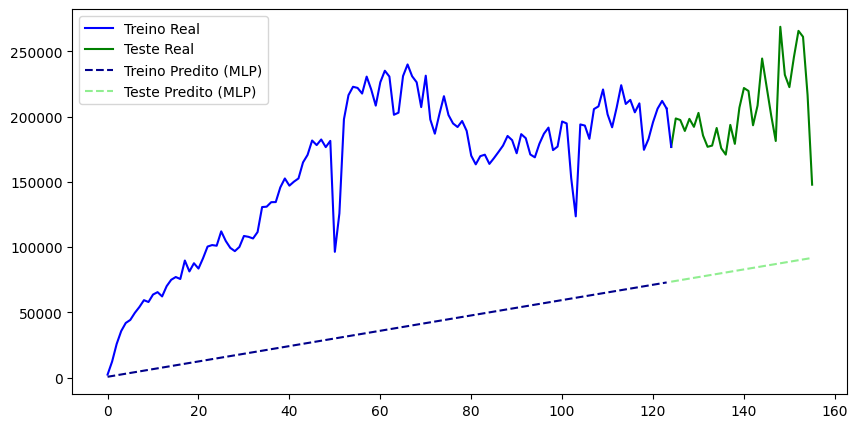

In [78]:
modelo_mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', 
                          max_iter=500, random_state=42)
modelo_mlp.fit(X_train, y_train)

# Previsões para treino e teste
train_pred_mlp = modelo_mlp.predict(X_train)
test_pred_mlp = modelo_mlp.predict(X_test)

# Avaliação do modelo
metrics_train_mlp = calculate_metrics(y_train, train_pred_mlp)
metrics_test_mlp = calculate_metrics(y_test, test_pred_mlp)

# Organizar os resultados
results_mlp = pd.DataFrame({
    'Treino': metrics_train_mlp,
    'Teste': metrics_test_mlp
}).T

# Exibir resultados
print("\n" + "="*50)
print("Comparação Treino vs Teste - MLP (Redes Neurais)")
print("="*50)
display(results_mlp.style.format({'MAE': '{:,.1f}', 'RMSE': '{:,.1f}', 'MAPE': '{:,.1f}%'}))

# Visualização do modelo MLP
plt.figure(figsize=(10, 5))

plt.plot(y_train.index, y_train, label='Treino Real', color='blue')
plt.plot(y_test.index, y_test, label='Teste Real', color='green')

plt.plot([y_train.index[-1], y_test.index[0]], 
         [y_train.iloc[-1], y_test.iloc[0]], 
         color='blue', linestyle='-')

plt.plot(y_train.index, train_pred_mlp, linestyle="--", color='darkblue', label="Treino Predito (MLP)")
plt.plot(y_test.index, test_pred_mlp, linestyle="--", color='lightgreen', label="Teste Predito (MLP)")

plt.legend()
plt.show()


Comparação Treino vs Teste - Random Forest


,MAE,RMSE,MAPE
Treino,"3,261.0","5,067.4",4.2%
Teste,"23,375.8","28,770.4",11.5%


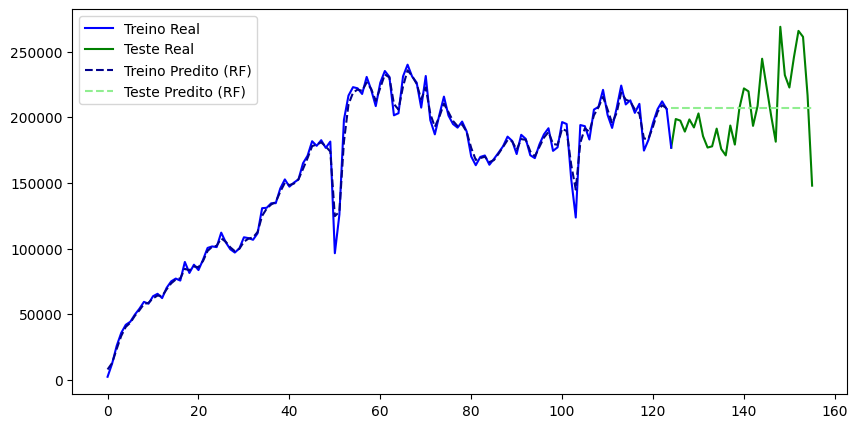

In [79]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Previsões para treino e teste
train_pred_rf = modelo_rf.predict(X_train)
test_pred_rf = modelo_rf.predict(X_test)

# Avaliação do modelo
metrics_train_rf = calculate_metrics(y_train, train_pred_rf)
metrics_test_rf = calculate_metrics(y_test, test_pred_rf)

# Organizar os resultados
results_rf = pd.DataFrame({
    'Treino': metrics_train_rf,
    'Teste': metrics_test_rf
}).T

# Exibir resultados
print("\n" + "="*50)
print("Comparação Treino vs Teste - Random Forest")
print("="*50)
display(results_rf.style.format({'MAE': '{:,.1f}', 'RMSE': '{:,.1f}', 'MAPE': '{:,.1f}%'}))

# Visualização do modelo Random Forest
plt.figure(figsize=(10, 5))

plt.plot(y_train.index, y_train, label='Treino Real', color='blue')
plt.plot(y_test.index, y_test, label='Teste Real', color='green')

plt.plot([y_train.index[-1], y_test.index[0]], 
         [y_train.iloc[-1], y_test.iloc[0]], 
         color='blue', linestyle='-')

plt.plot(y_train.index, train_pred_rf, linestyle="--", color='darkblue', label="Treino Predito (RF)")
plt.plot(y_test.index, test_pred_rf, linestyle="--", color='lightgreen', label="Teste Predito (RF)")

plt.legend()
plt.show()


🔍 Comparação dos Modelos - Métricas


,MAE,RMSE,MAPE,R²
ARIMA,"29,894.0","36,200.3",15.9%,-0.588
Regressão Linear,"50,744.6","56,376.9",26.7%,-2.851
MLP (Redes Neurais),"122,594.2","125,396.9",59.1%,-18.053
Random Forest,"23,375.8","28,770.4",11.5%,-0.003


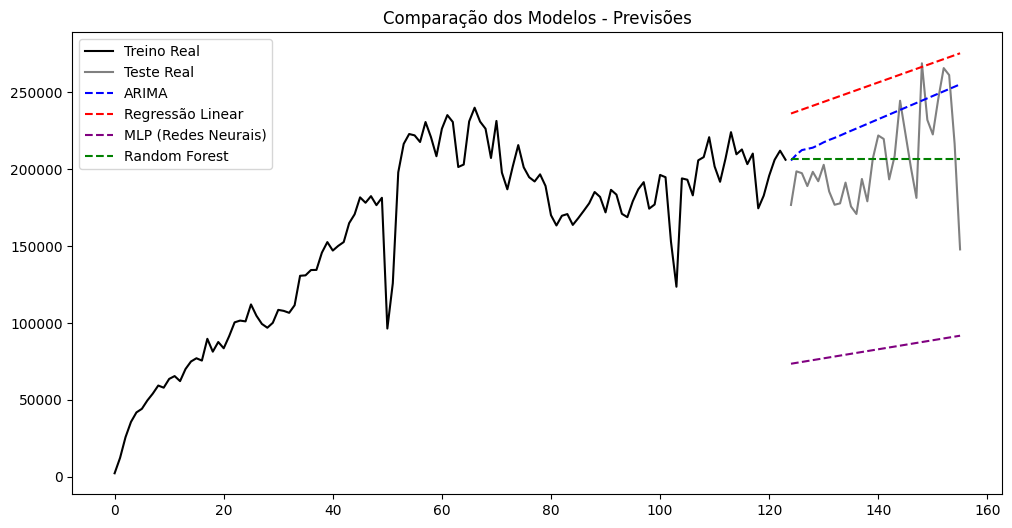

In [80]:
def calculate_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R²': r2_score(y_true, y_pred)
    }

# 🔹 Modelo ARIMA
modelo_arima = auto_arima(y_train, seasonal=True, trace=False, error_action='ignore', suppress_warnings=True)
train_pred_arima = modelo_arima.predict_in_sample()
test_pred_arima = modelo_arima.predict(n_periods=len(y_test))

# 🔹 Modelo de Regressão Linear
modelo_lr = LinearRegression()
X_train_num = np.arange(len(y_train)).reshape(-1, 1)
X_test_num = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1)
modelo_lr.fit(X_train_num, y_train)
train_pred_lr = modelo_lr.predict(X_train_num)
test_pred_lr = modelo_lr.predict(X_test_num)

# 🔹 Modelo de Redes Neurais (MLP)
modelo_mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
modelo_mlp.fit(X_train_num, y_train)
train_pred_mlp = modelo_mlp.predict(X_train_num)
test_pred_mlp = modelo_mlp.predict(X_test_num)

# 🔹 Modelo Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_num, y_train)
train_pred_rf = modelo_rf.predict(X_train_num)
test_pred_rf = modelo_rf.predict(X_test_num)

# 🔹 Cálculo das métricas
metrics = pd.DataFrame({
    "ARIMA": calculate_metrics(y_test, test_pred_arima),
    "Regressão Linear": calculate_metrics(y_test, test_pred_lr),
    "MLP (Redes Neurais)": calculate_metrics(y_test, test_pred_mlp),
    "Random Forest": calculate_metrics(y_test, test_pred_rf),
}).T

# 🔹 Exibir resultados formatados
metrics_formatted = metrics.style.format({
    'MAE': '{:,.1f}',
    'RMSE': '{:,.1f}',
    'MAPE': '{:,.1f}%',
    'R²': '{:.3f}'
}).set_caption("Desempenho dos Modelos").background_gradient(cmap='Blues')

print("\n" + "="*50)
print("🔍 Comparação dos Modelos - Métricas")
print("="*50)
display(metrics_formatted)

# 🔹 Gráfico comparando os modelos
plt.figure(figsize=(12, 6))

plt.plot(y_train.index, y_train, label='Treino Real', color='black')
plt.plot(y_test.index, y_test, label='Teste Real', color='gray')

plt.plot(y_test.index, test_pred_arima, linestyle="--", color='blue', label="ARIMA")
plt.plot(y_test.index, test_pred_lr, linestyle="--", color='red', label="Regressão Linear")
plt.plot(y_test.index, test_pred_mlp, linestyle="--", color='purple', label="MLP (Redes Neurais)")
plt.plot(y_test.index, test_pred_rf, linestyle="--", color='green', label="Random Forest")

plt.legend()
plt.title("Comparação dos Modelos - Previsões")
plt.show()